#Import Library

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn import tree
import keras
from keras.models import Sequential
from google.colab import drive

##Mount Google Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET_DIR = "/content/drive/MyDrive/dataset/penyakit_cabai"

HEALTH = os.path.join(DATASET_DIR, "sehat")
YELLOW_LIGHT = os.path.join(DATASET_DIR, "yellow_light")
KRITING = os.path.join(DATASET_DIR, "kiriting")
LEAF_SPORT = os.path.join(DATASET_DIR, "leaf_spot")

# TAHAP 1: LOADING DAN EXPLORASI DATA

##Kategori yang akan digunakan

In [4]:
CATEGORIES = ["sehat", "yellow_light", "kriting", "leaf_spot"]

## Fungsi untuk load images

In [5]:
def load_images_from_folder(folder, categories, max_images=100):
    images = []
    labels = []

    for category in categories:
        path = os.path.join(folder, category)
        class_num = categories.index(category)

        print(f"Loading {category}...")
        count = 0

        for img_name in os.listdir(path):
            if max_images is not None and count >= max_images:
                break
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    images.append(img)
                    labels.append(class_num)
                    count += 1
            except Exception as e:
                pass

    return np.array(images), np.array(labels)

## Load & Split Dataset

In [40]:
print("\nLoading all images from dataset...")
all_images, all_labels = load_images_from_folder(DATASET_DIR, CATEGORIES, max_images=100)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

print(f"\nTotal images loaded: {len(all_images)}")
print(f"Total training images: {len(X_train_raw)}")
print(f"Total testing images: {len(X_test_raw)}")


Loading all images from dataset...
Loading sehat...
Loading yellow_light...
Loading kriting...
Loading leaf_spot...

Total images loaded: 389
Total training images: 272
Total testing images: 117


## Visualisasi sample images

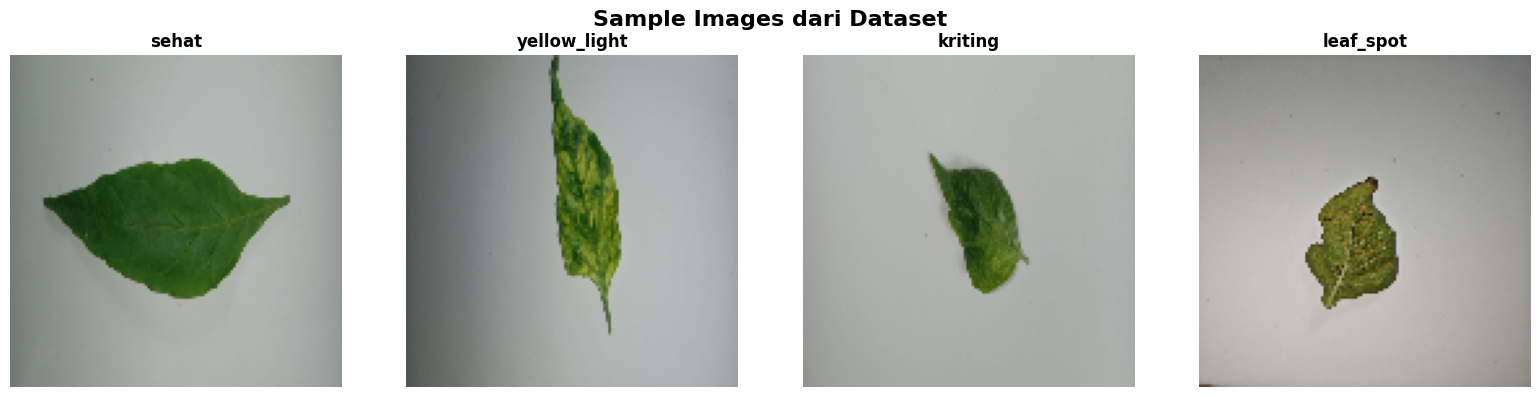

In [39]:
plt.figure(figsize=(16, 4))
plt.suptitle("Sample Images dari Dataset", fontsize=16, fontweight='bold')

# Ambil 1 sampel dari setiap kelas
for i, category in enumerate(CATEGORIES):
    # Cari index gambar pertama dari kelas ini
    idx = np.where(y_train == i)[0][0]

    plt.subplot(1, 4, i + 1)

    # Konversi BGR -> RGB
    img_rgb = cv2.cvtColor(X_train_raw[idx], cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

    plt.title(category, fontsize=12, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

# TAHAP 2: SEGMENTASI HSV - DETEKSI WARNA PADA DAUN

HSV digunakan untuk memisahkan area sehat (hijau) dan area sakit (coklat/kuning)


In [41]:
def hsv_segmentation(image, visualize=True):
    """Segmentasi menggunakan HSV untuk deteksi 3 warna: hijau (sehat/kriting), kuning (yellow_light), dan coklat (leaf_spot)"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Range untuk warna hijau (daun sehat/kriting)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Range untuk warna kuning (yellow_light)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([35, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Range untuk warna coklat/gelap (leaf_spot - titik lubang coklat)
    lower_brown = np.array([10, 50, 20])
    upper_brown = np.array([20, 255, 200])
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)

    # Hitung persentase area
    total_pixels = mask_green.size
    green_pixels = np.sum(mask_green > 0)
    yellow_pixels = np.sum(mask_yellow > 0)
    brown_pixels = np.sum(mask_brown > 0)

    green_percentage = (green_pixels / total_pixels) * 100
    yellow_percentage = (yellow_pixels / total_pixels) * 100
    brown_percentage = (brown_pixels / total_pixels) * 100

    if visualize:
        plt.figure(figsize=(20, 4))

        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(hsv)
        plt.title("HSV Color Space")
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(mask_green, cmap='gray')
        plt.title(f"Green Mask\n({green_percentage:.2f}%)")
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(mask_yellow, cmap='gray')
        plt.title(f"Yellow Mask\n({yellow_percentage:.2f}%)")
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(mask_brown, cmap='gray')
        plt.title(f"Brown Mask\n({brown_percentage:.2f}%)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return green_percentage, yellow_percentage, brown_percentage

# TAHAP 3: THRESHOLDING

Threshold digunakan untuk mendeteksi kontur dan bentuk lesi pada daun

## Contoh visualisasi HSV segmentation


Contoh segmentasi HSV pada gambar Sehat:


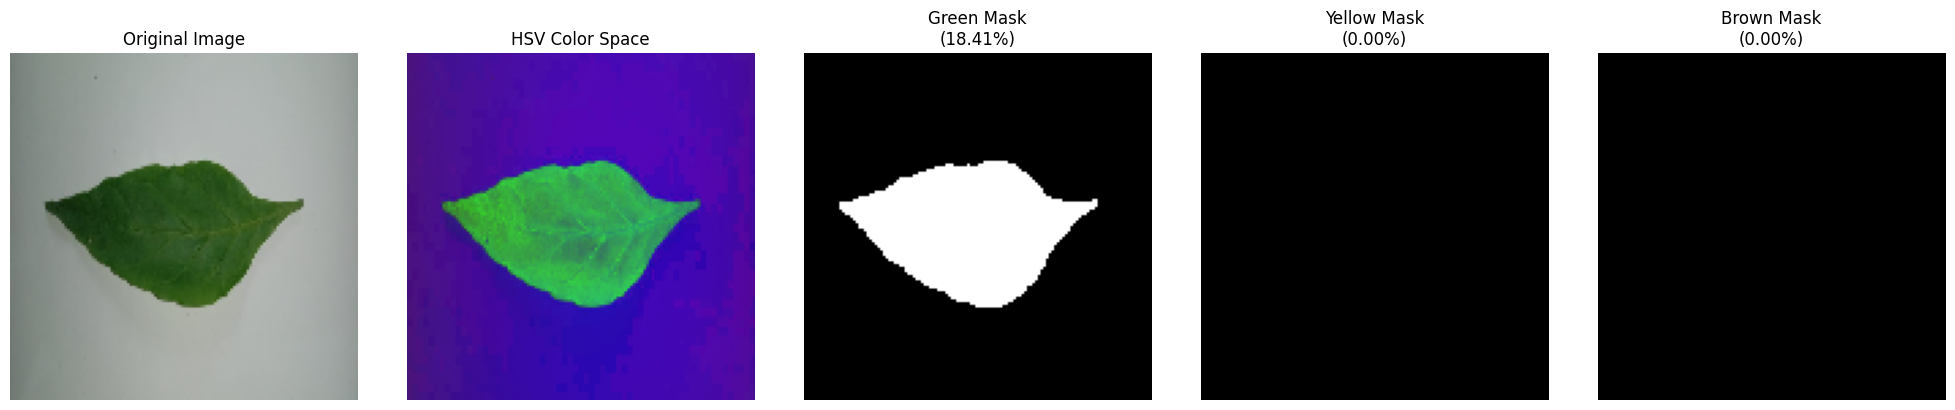


Contoh segmentasi HSV pada gambar Yellow_Light:


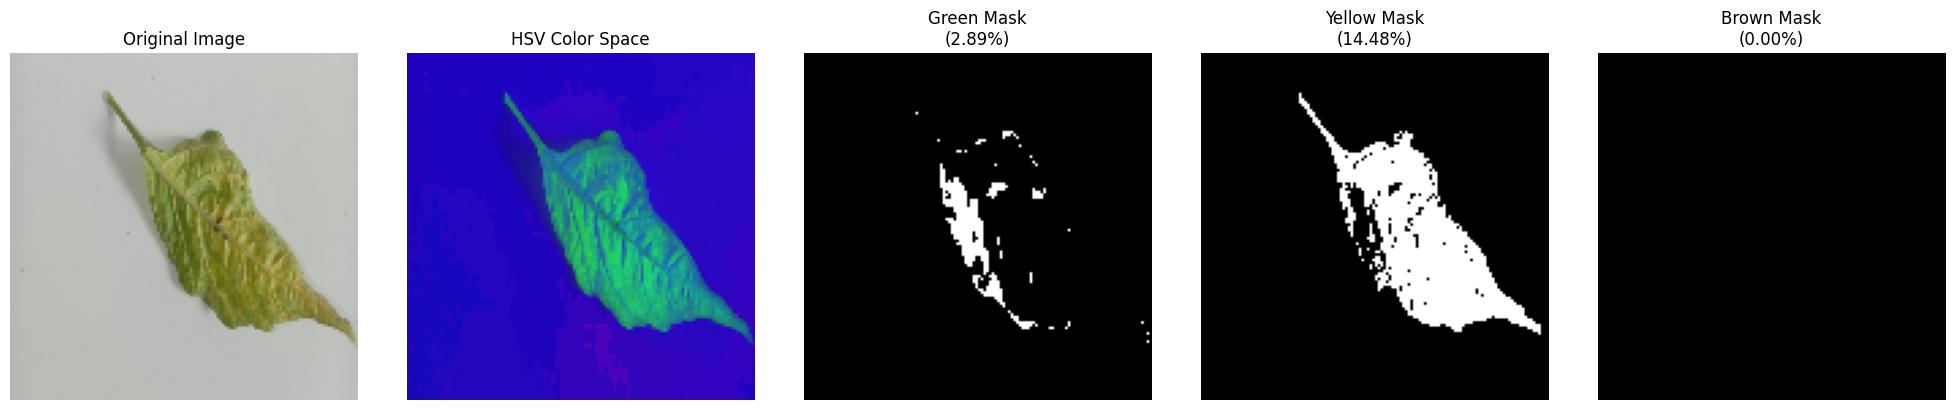


Contoh segmentasi HSV pada gambar Kriting:


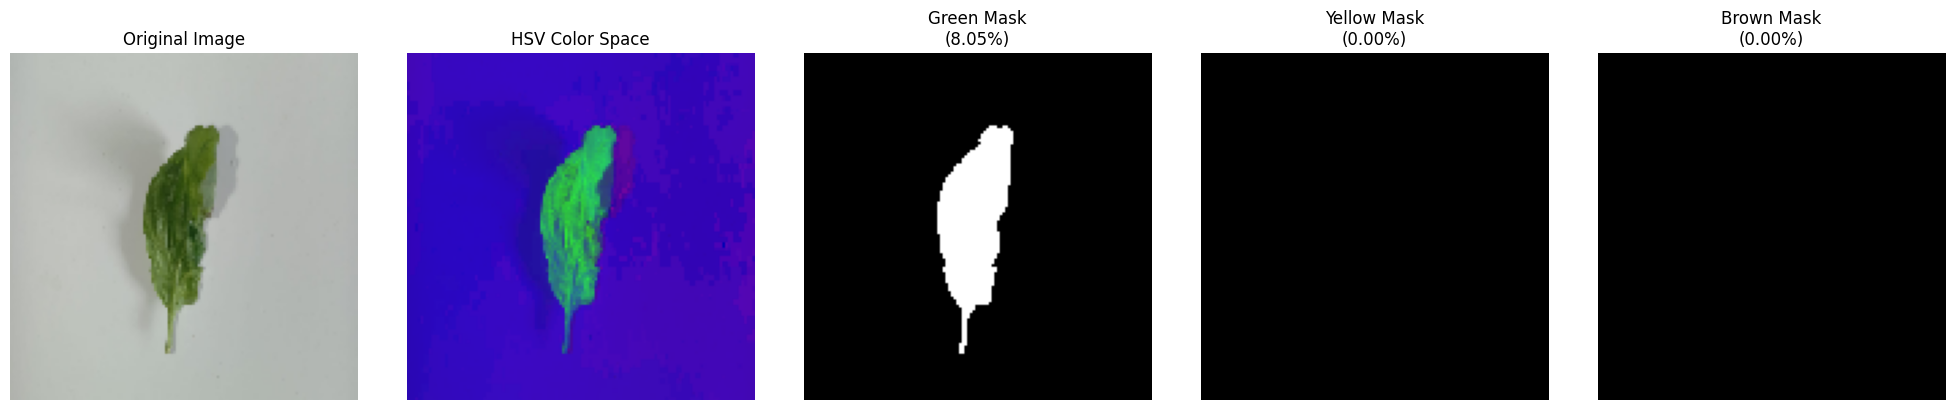


Contoh segmentasi HSV pada gambar Leaf_Spot:


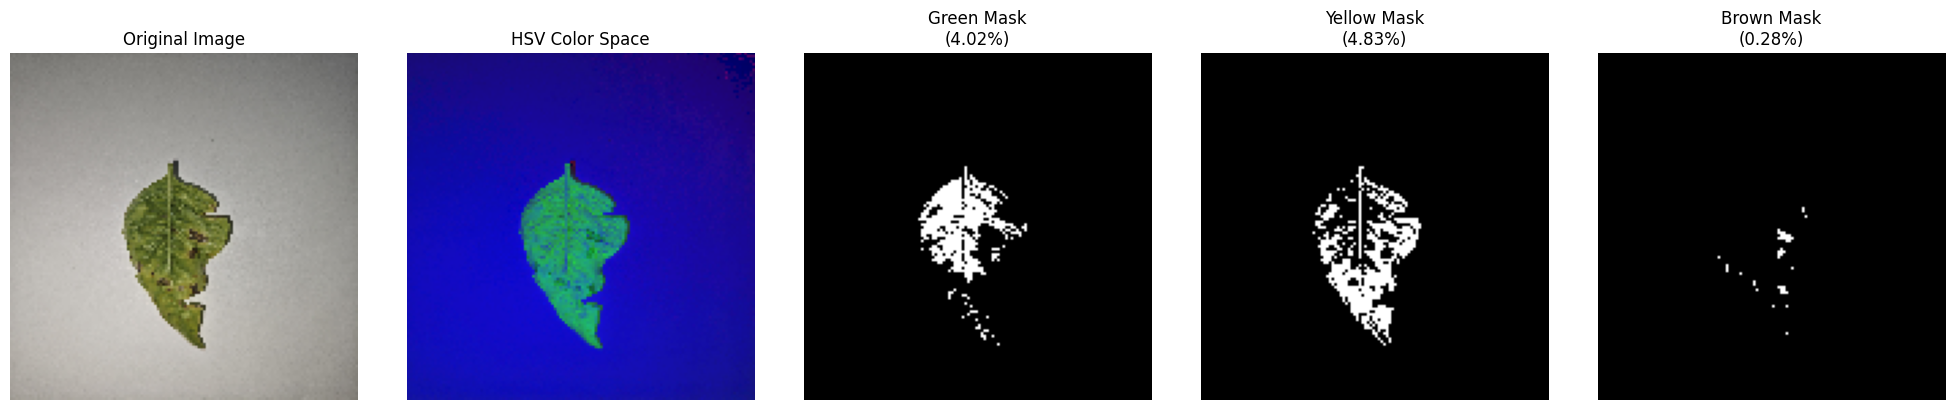

(np.float64(4.01611328125), np.float64(4.833984375), np.float64(0.28076171875))

In [52]:
print("\nContoh segmentasi HSV pada gambar Sehat:")
healthy_idx = np.where(y_train == 0)[0][1]  # Sehat
hsv_segmentation(X_train_raw[healthy_idx], visualize=True)

print("\nContoh segmentasi HSV pada gambar Yellow_Light:")
yellow_idx = np.where(y_train == 1)[0][1]  # Yellow_Light
hsv_segmentation(X_train_raw[yellow_idx], visualize=True)

print("\nContoh segmentasi HSV pada gambar Kriting:")
kriting_idx = np.where(y_train == 2)[0][1]  # Kriting
hsv_segmentation(X_train_raw[kriting_idx], visualize=True)

print("\nContoh segmentasi HSV pada gambar Leaf_Spot:")
leafspot_idx = np.where(y_train == 3)[0][0]  # Leaf_Spot
hsv_segmentation(X_train_raw[leafspot_idx], visualize=True)

In [53]:
def threshold_analysis(image, visualize=True):
    """Analisis threshold untuk deteksi edge dan kompleksitas tekstur"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Blur untuk mengurangi noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Binary threshold
    _, binary = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)

    # Otsu threshold
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Adaptive threshold
    adaptive = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)

    # Deteksi edge dengan Canny
    edges = cv2.Canny(blur, 30, 100)

    # Hitung kontur dari edge
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)

    # Hitung edge density (kompleksitas tekstur berdasarkan edge)
    edge_density = np.sum(edges > 0) / edges.size * 100

    # Hitung rata-rata intensitas area gelap (untuk deteksi bercak/lubang)
    dark_threshold = 80  # Nilai intensitas untuk area gelap
    dark_areas = gray < dark_threshold
    dark_area_percentage = np.sum(dark_areas) / gray.size * 100

    if visualize:
        plt.figure(figsize=(20, 8))

        plt.subplot(2, 4, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, 4, 2)
        plt.imshow(gray, cmap='gray')
        plt.title("Grayscale")
        plt.axis('off')

        plt.subplot(2, 4, 3)
        plt.imshow(binary, cmap='gray')
        plt.title("Binary Threshold")
        plt.axis('off')

        plt.subplot(2, 4, 4)
        plt.imshow(otsu, cmap='gray')
        plt.title("Otsu Threshold")
        plt.axis('off')

        plt.subplot(2, 4, 5)
        plt.imshow(adaptive, cmap='gray')
        plt.title("Adaptive Threshold")
        plt.axis('off')

        plt.subplot(2, 4, 6)
        plt.imshow(edges, cmap='gray')
        plt.title(f"Canny Edges\n(Density: {edge_density:.2f}%)")
        plt.axis('off')

        plt.subplot(2, 4, 7)
        plt.imshow(dark_areas, cmap='gray')
        plt.title(f"Dark Areas\n({dark_area_percentage:.2f}%)")
        plt.axis('off')

        # Visualisasi kontur pada gambar asli
        plt.subplot(2, 4, 8)
        img_contours = image.copy()
        cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
        plt.title(f"Contours\n(Count: {num_contours})")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return num_contours, edge_density, dark_area_percentage


=== VISUALISASI THRESHOLD ANALYSIS ===


Contoh threshold analysis pada gambar Sehat:


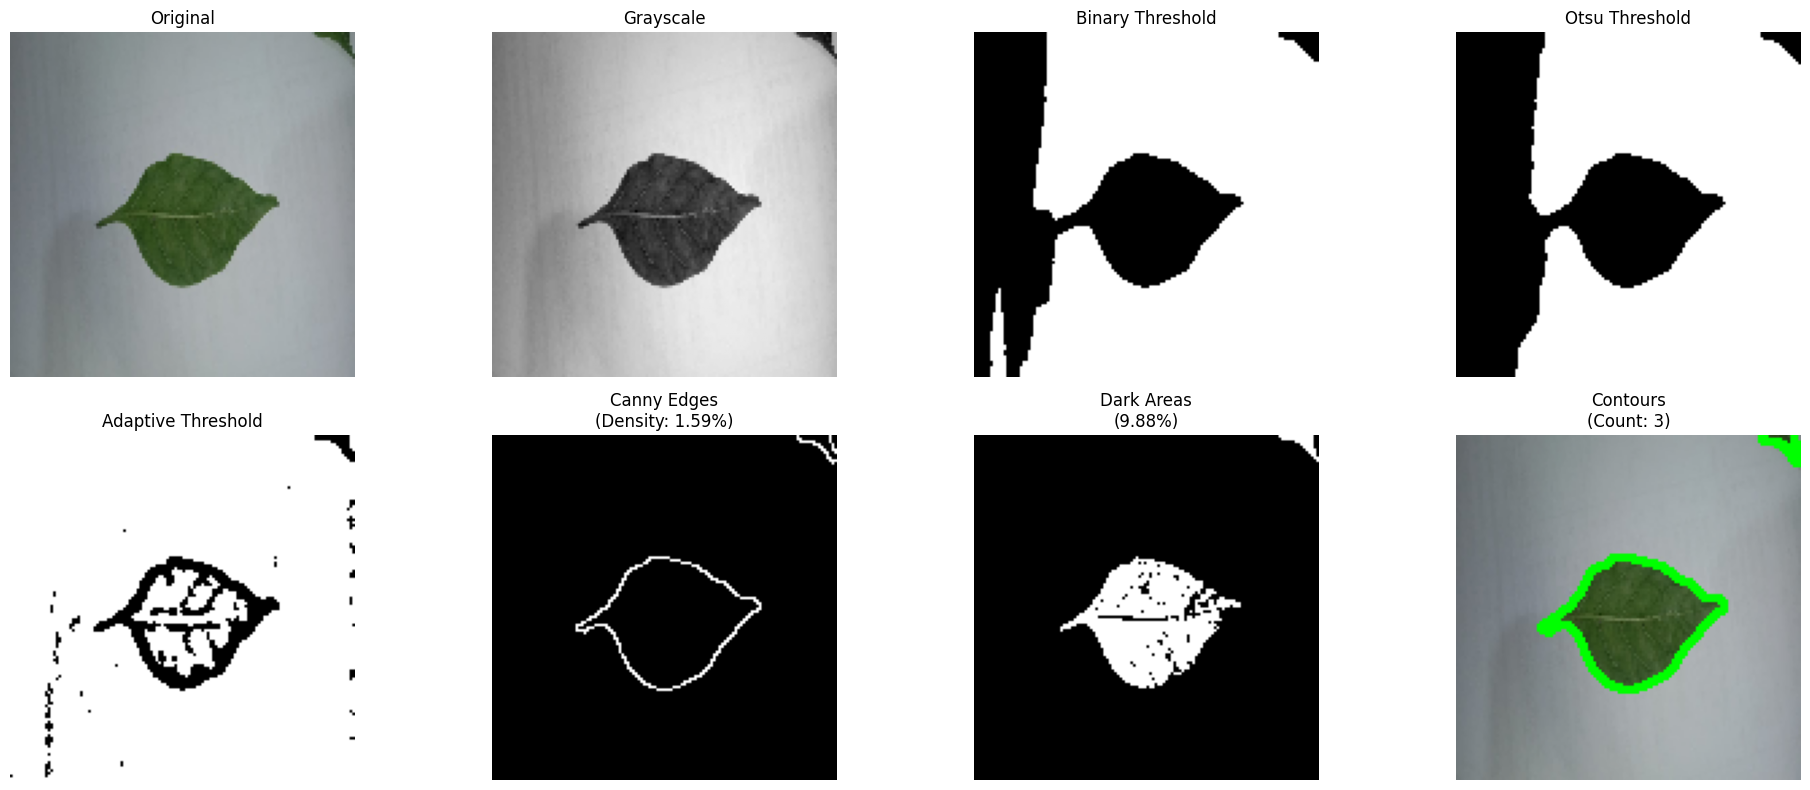


Contoh threshold analysis pada gambar Yellow_Light:


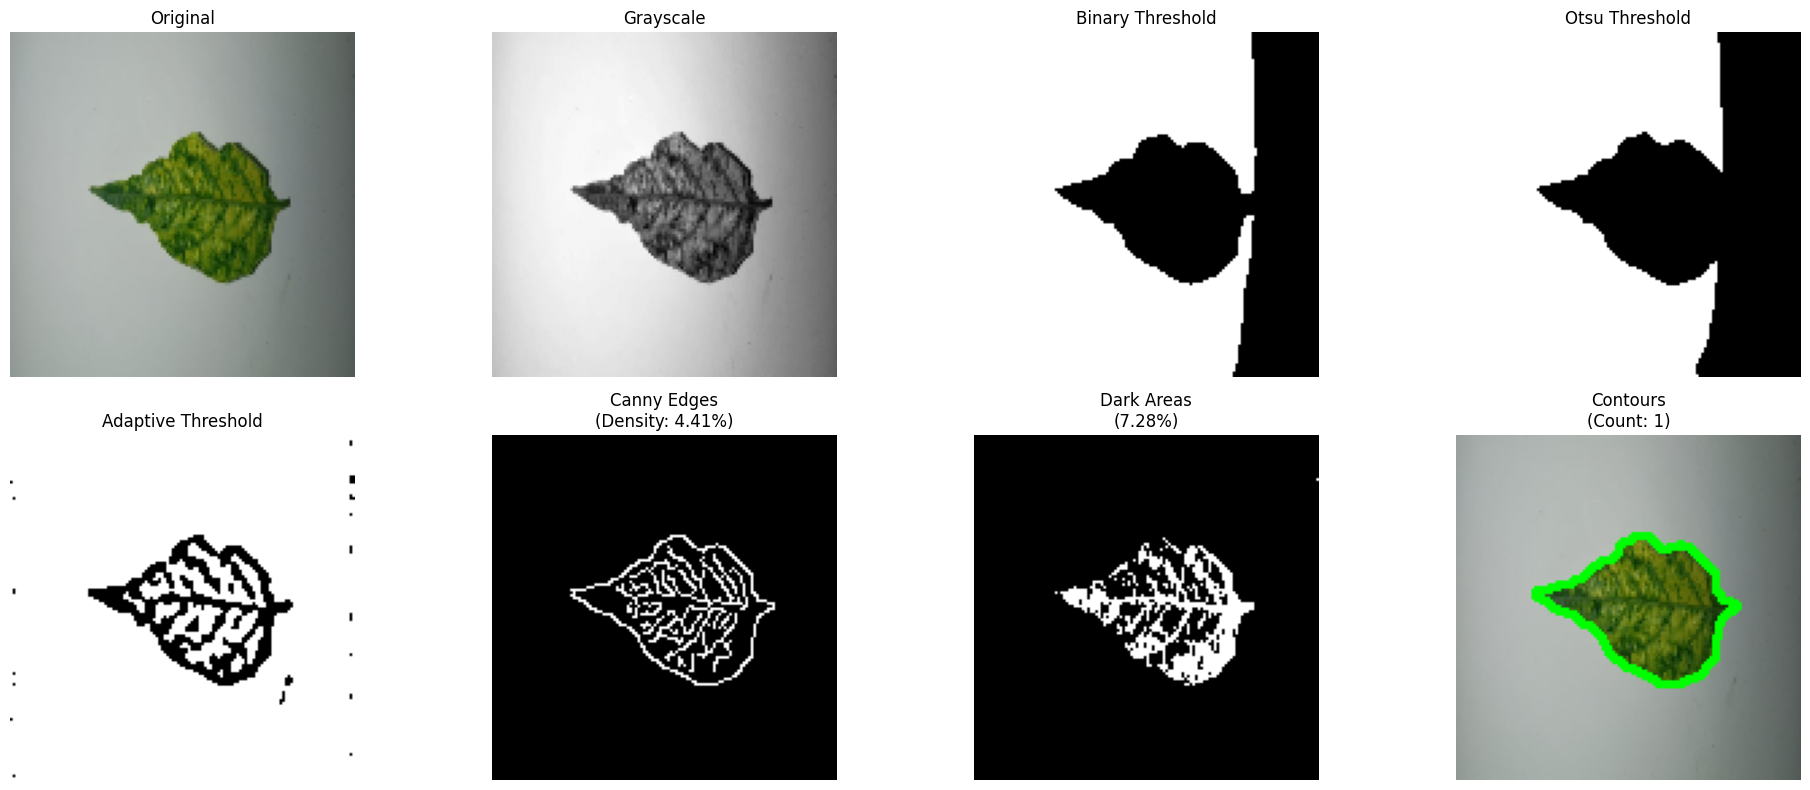


Contoh threshold analysis pada gambar Kriting:


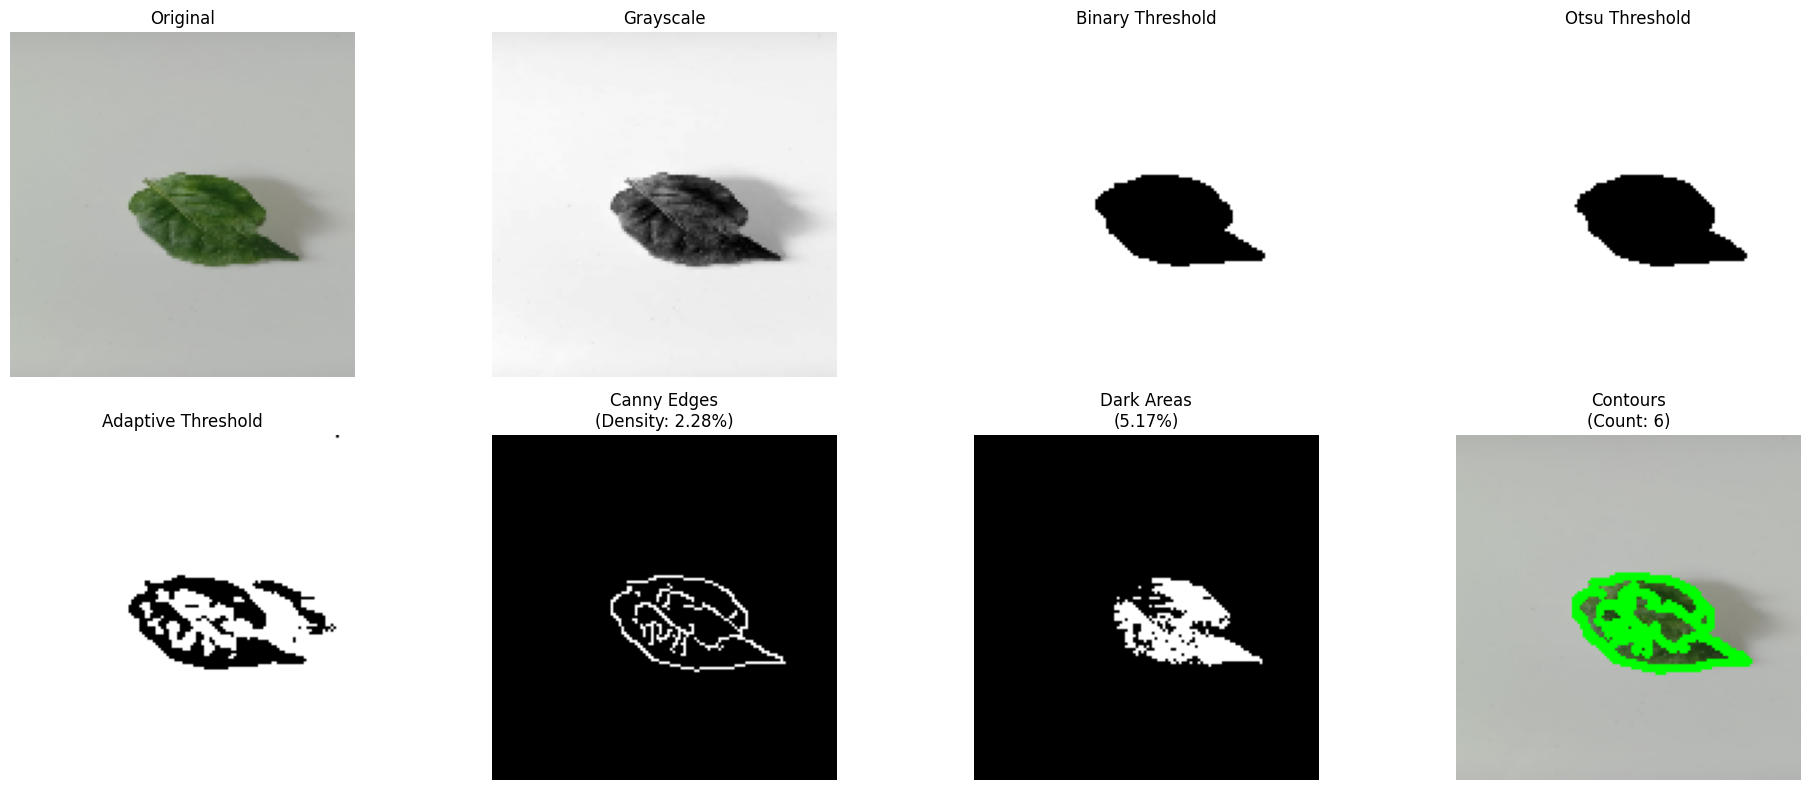


Contoh threshold analysis pada gambar Leaf_Spot:


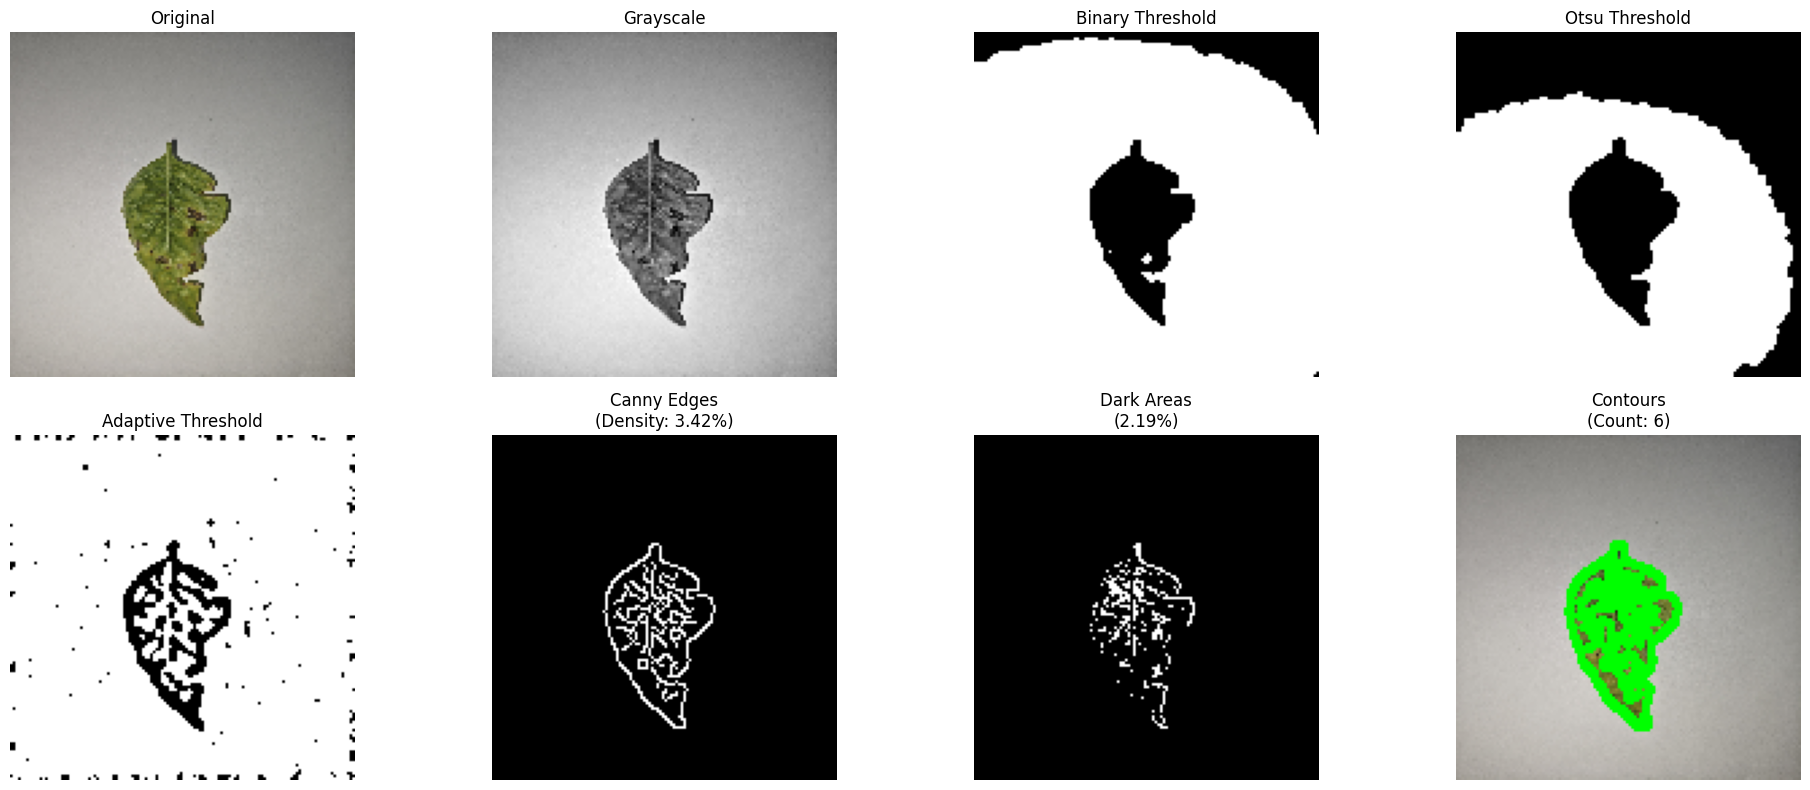

(6, np.float64(3.424072265625), np.float64(2.191162109375))

In [54]:
# Tambahkan blok kode baru ini
print("\n=== VISUALISASI THRESHOLD ANALYSIS ===\n")

print("\nContoh threshold analysis pada gambar Sehat:")
healthy_idx = np.where(y_train == 0)[0][0]
threshold_analysis(X_train_raw[healthy_idx], visualize=True)

print("\nContoh threshold analysis pada gambar Yellow_Light:")
yellow_idx = np.where(y_train == 1)[0][0]
threshold_analysis(X_train_raw[yellow_idx], visualize=True)

print("\nContoh threshold analysis pada gambar Kriting:")
kriting_idx = np.where(y_train == 2)[0][0]
threshold_analysis(X_train_raw[kriting_idx], visualize=True)

print("\nContoh threshold analysis pada gambar Leaf_Spot:")
leafspot_idx = np.where(y_train == 3)[0][0]
threshold_analysis(X_train_raw[leafspot_idx], visualize=True)

# TAHAP 4: EKSTRAKSI FITUR - DARI HSV & THRESHOLD KE DATA NUMERIK

Mengubah gambar menjadi fitur numerik yang bisa digunakan untuk ML

## Ekstrak fitur untuk semua gambar

In [55]:
def extract_features(image):
    """Ekstrak fitur dari gambar menggunakan HSV untuk 3 warna: hijau, kuning, dan coklat"""
    # Fitur HSV - return 3 nilai persentase warna
    green_pct, yellow_pct, brown_pct = hsv_segmentation(image, visualize=False)

    # Fitur Threshold - return 3 nilai: contours, edge_density, dark_area
    num_contours, edge_density, dark_area_pct = threshold_analysis(image, visualize=False)

    # Segmentasi daun untuk fitur warna rata-rata
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Mask untuk hijau
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Mask untuk kuning
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([35, 255, 255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Mask untuk coklat
    lower_brown = np.array([10, 50, 20])
    upper_brown = np.array([20, 255, 200])
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)

    # Gabungkan semua mask untuk mendapatkan area daun keseluruhan
    leaf_mask = cv2.bitwise_or(mask_green, mask_yellow)
    leaf_mask = cv2.bitwise_or(leaf_mask, mask_brown)

    # Fitur warna rata-rata (hanya pada area daun)
    hsv_masked = cv2.bitwise_and(hsv, hsv, mask=leaf_mask)
    mean_hue = np.mean(hsv_masked[:, :, 0][leaf_mask > 0]) if np.sum(leaf_mask) > 0 else 0
    mean_saturation = np.mean(hsv_masked[:, :, 1][leaf_mask > 0]) if np.sum(leaf_mask) > 0 else 0
    mean_value = np.mean(hsv_masked[:, :, 2][leaf_mask > 0]) if np.sum(leaf_mask) > 0 else 0

    # Fitur tekstur (standard deviation, hanya pada area daun)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_masked = gray[leaf_mask > 0]
    texture_std = np.std(gray_masked) if len(gray_masked) > 0 else 0

    # Return 11 fitur total
    return [green_pct, yellow_pct, brown_pct,
            num_contours, edge_density, dark_area_pct,
            mean_hue, mean_saturation, mean_value, texture_std,
            np.sum(leaf_mask > 0) / leaf_mask.size * 100]  # Total area daun (%)

In [56]:
print("\nMengekstrak fitur dari semua gambar training...")
features_train = []
for i, img in enumerate(X_train_raw):
    # Mengubah kondisi agar progres terlihat lebih sering
    if i % 5 == 0 or i == len(X_train_raw) - 1: # Cetak setiap 5 gambar atau di akhir
        print(f"Progress: {i}/{len(X_train_raw)}")
    features = extract_features(img)
    features_train.append(features)

features_train = np.array(features_train)

print("\nMengekstrak fitur dari semua gambar testing...")
features_test = []
for i, img in enumerate(X_test_raw):
    # Mengubah kondisi agar progres terlihat lebih sering
    if i % 5 == 0 or i == len(X_test_raw) - 1: # Cetak setiap 5 gambar atau di akhir
        print(f"Progress: {i}/{len(X_test_raw)}")
    features = extract_features(img)
    features_test.append(features)

features_test = np.array(features_test)


Mengekstrak fitur dari semua gambar training...
Progress: 0/272
Progress: 5/272
Progress: 10/272
Progress: 15/272
Progress: 20/272
Progress: 25/272
Progress: 30/272
Progress: 35/272
Progress: 40/272
Progress: 45/272
Progress: 50/272
Progress: 55/272
Progress: 60/272
Progress: 65/272
Progress: 70/272
Progress: 75/272
Progress: 80/272
Progress: 85/272
Progress: 90/272
Progress: 95/272
Progress: 100/272
Progress: 105/272
Progress: 110/272
Progress: 115/272
Progress: 120/272
Progress: 125/272
Progress: 130/272
Progress: 135/272
Progress: 140/272
Progress: 145/272
Progress: 150/272
Progress: 155/272
Progress: 160/272
Progress: 165/272
Progress: 170/272
Progress: 175/272
Progress: 180/272
Progress: 185/272
Progress: 190/272
Progress: 195/272
Progress: 200/272
Progress: 205/272
Progress: 210/272
Progress: 215/272
Progress: 220/272
Progress: 225/272
Progress: 230/272
Progress: 235/272
Progress: 240/272
Progress: 245/272
Progress: 250/272
Progress: 255/272
Progress: 260/272
Progress: 265/272
P

## Buat DataFrame untuk analisis

In [57]:
# Update nama fitur sesuai dengan perubahan
feature_names = ['Green%', 'Yellow%', 'Brown%',
                 'Num_Contours', 'Edge_Density', 'Dark_Area%',
                 'Mean_Hue', 'Mean_Saturation', 'Mean_Value', 'Texture_STD', 'Total_Leaf_Area%']

df_features = pd.DataFrame(features_train, columns=feature_names)
df_features['Label'] = y_train
df_features['Class'] = df_features['Label'].map({
    0: 'Healthy',
    1: 'Yellow_Light',
    2: 'Kriting',
    3: 'Leaf_Spot'
})

print("\nSample fitur yang diekstrak:")
print(df_features.head(10))

print("\nStatistik fitur per kelas:")
print(df_features.groupby('Class')[feature_names].mean())


Sample fitur yang diekstrak:
      Green%    Yellow%    Brown%  Num_Contours  Edge_Density  Dark_Area%  \
0   4.016113   4.833984  0.280762           6.0      3.424072    2.191162   
1   0.622559   6.384277  0.006104           3.0      2.691650    1.855469   
2  13.110352   1.599121  0.000000           1.0      4.412842    7.275391   
3   8.630371   0.000000  0.000000           6.0      2.276611    5.169678   
4   8.050537   0.000000  0.000000           1.0      2.124023    3.118896   
5   5.908203   0.067139  0.006104           1.0      2.209473    6.774902   
6   9.136963   0.000000  0.000000           2.0      2.593994    5.340576   
7   2.893066  14.477539  0.000000          12.0      5.596924    0.213623   
8  11.468506   0.000000  0.000000           3.0      1.593018    9.881592   
9  18.414307   0.000000  0.000000           1.0      1.684570   16.906738   

    Mean_Hue  Mean_Saturation  Mean_Value  Texture_STD  Total_Leaf_Area%  \
0  33.571964       146.252624  110.458021    2

## Visualisasi distribusi fitur untuk semua kelas

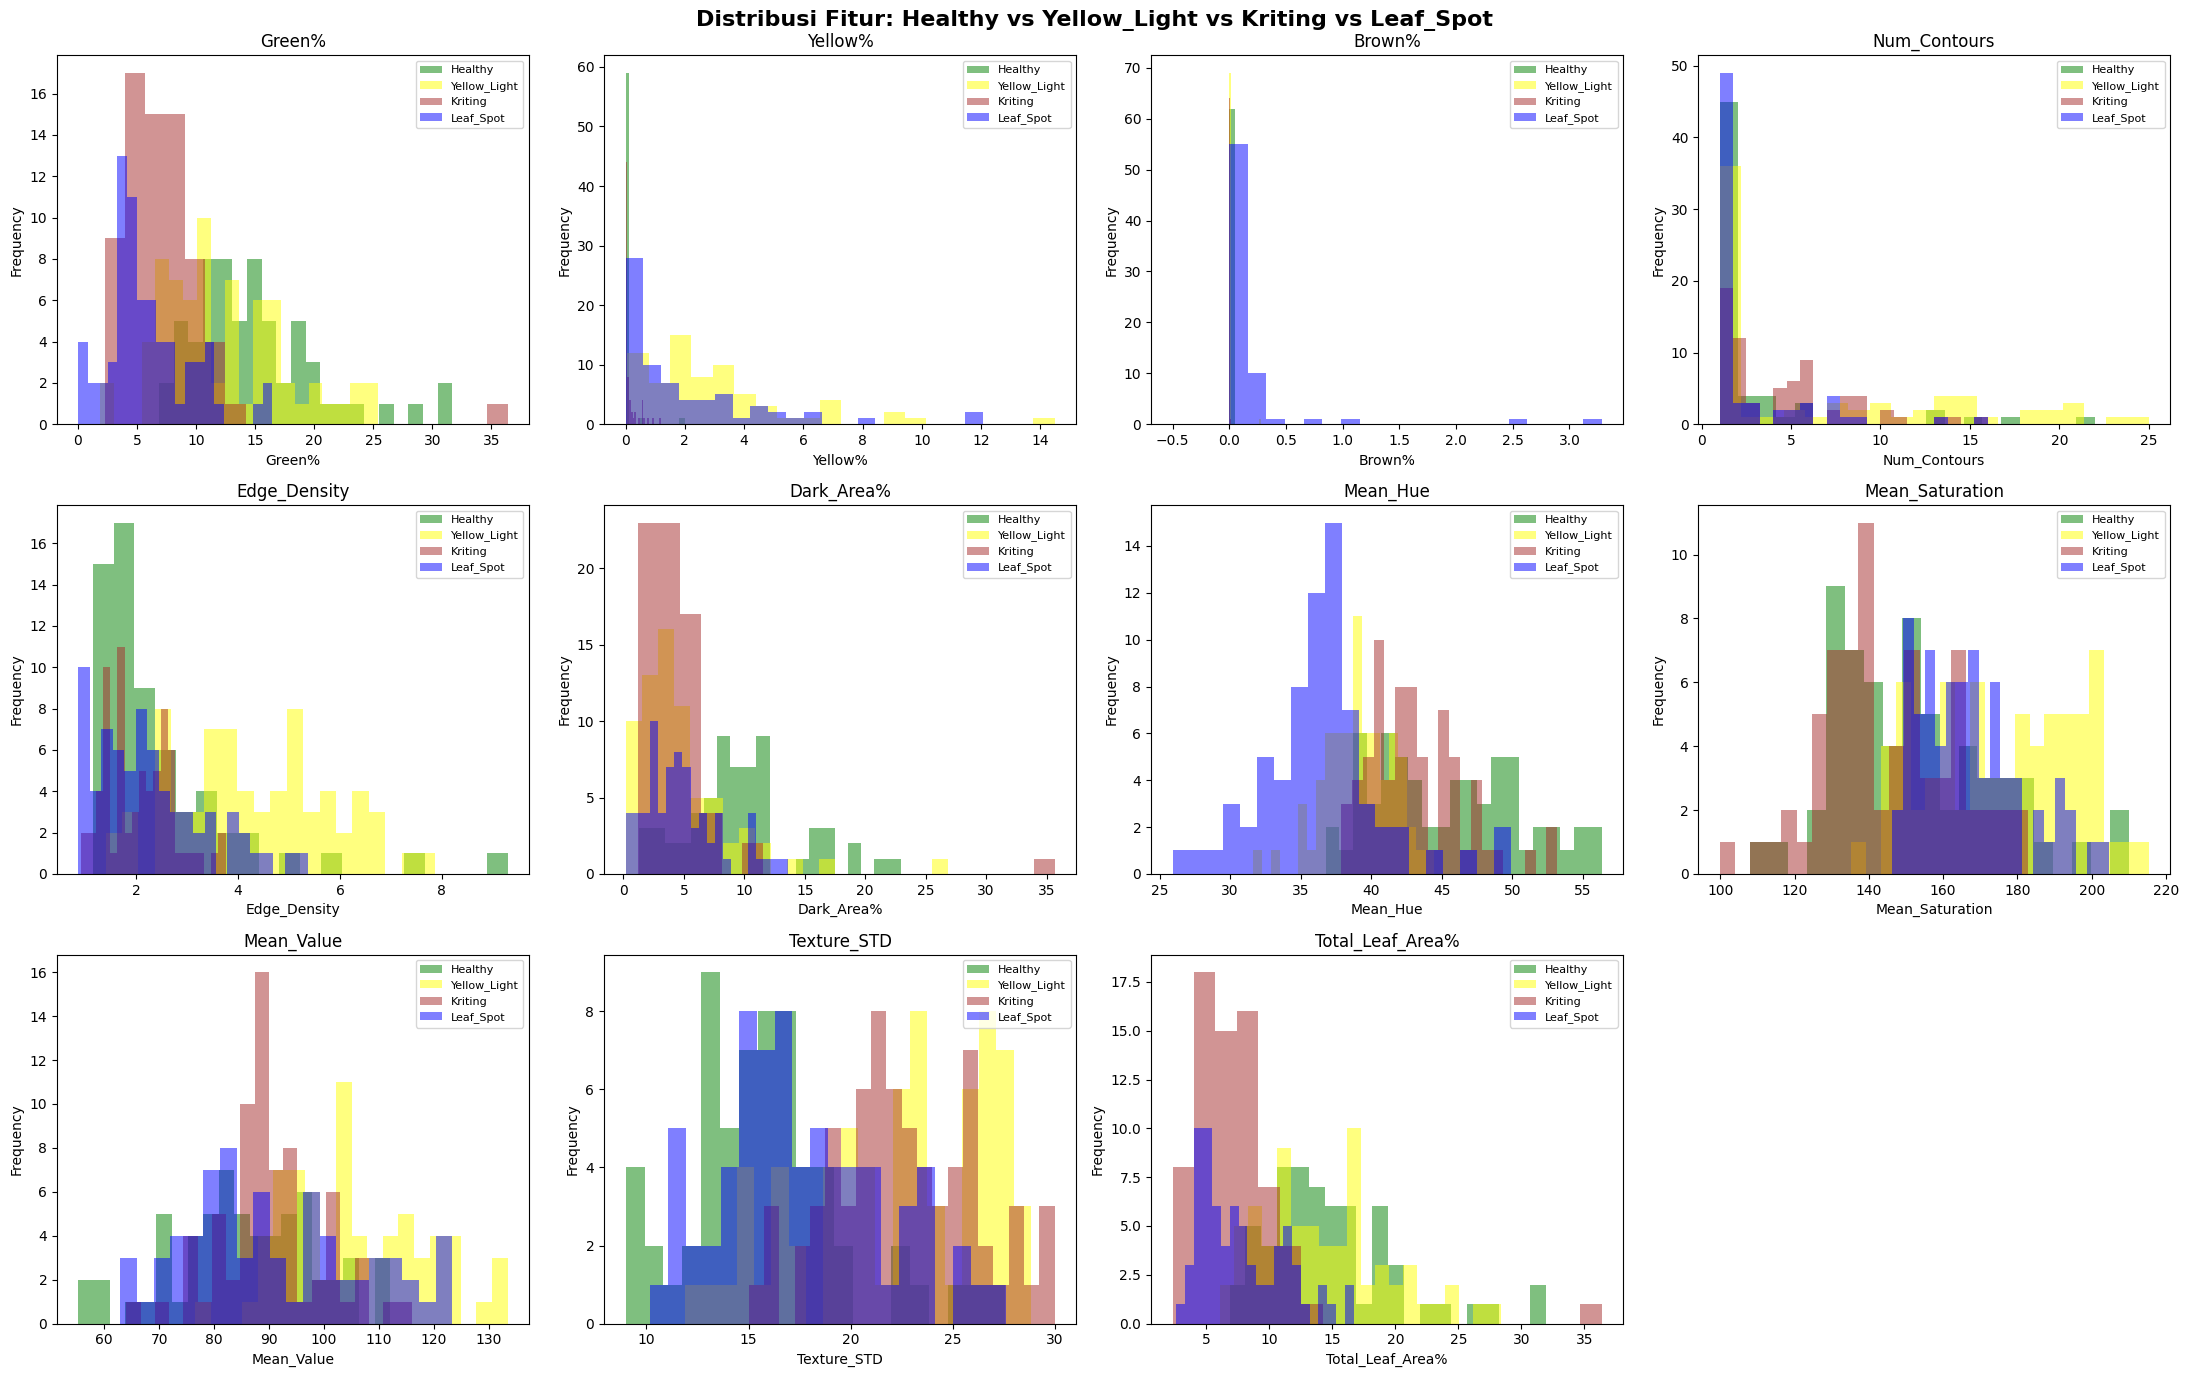

In [58]:
plt.figure(figsize=(22, 14))
plt.suptitle("Distribusi Fitur: Healthy vs Yellow_Light vs Kriting vs Leaf_Spot",
             fontsize=16, fontweight='bold')

colors = ['green', 'yellow', 'brown', 'blue']
class_names = ['Healthy', 'Yellow_Light', 'Kriting', 'Leaf_Spot']

for i, feature in enumerate(feature_names):
    plt.subplot(3, 4, i + 1)
    for label, color, name in zip([0, 1, 2, 3], colors, class_names):
        data = df_features[df_features['Label'] == label][feature]
        plt.hist(data, bins=20, alpha=0.5, label=name, color=color)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(feature)
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

#TAHAP 5: REGRESI LINEAR

## Disease Score untuk Regresi

In [59]:
# Untuk regresi, kita fokus pada deteksi tingkat keparahan penyakit
# Kombinasi Yellow% + Brown% sebagai disease score
disease_score = features_train[:, 1] + features_train[:, 2]  # Yellow% + Brown%

print("\nStatistik Disease Score per kelas:")
df_features['Disease_Score'] = disease_score
print(df_features.groupby('Class')['Disease_Score'].describe())


Statistik Disease Score per kelas:
              count      mean       std       min       25%       50%  \
Class                                                                   
Healthy        62.0  0.081216  0.348160  0.000000  0.000000  0.000000   
Kriting        70.0  0.130790  0.242355  0.000000  0.000000  0.015259   
Leaf_Spot      70.0  2.154628  2.637273  0.000000  0.277710  1.126099   
Yellow_Light   70.0  2.974941  2.641259  0.061035  1.332092  2.322388   

                   75%        max  
Class                              
Healthy       0.012207   2.020264  
Kriting       0.122070   1.202393  
Leaf_Spot     3.138733  12.127686  
Yellow_Light  3.652954  14.477539  


##Persiapan Data Regresi

In [60]:
# Fitur untuk regresi: semua kecuali Yellow%, Brown%, dan Disease_Score itu sendiri
# Kita gunakan: Green%, Green_Threshold, Yellow_Threshold, Brown_Threshold, Mean_Hue, Mean_Saturation, Mean_Value, Texture_STD, Total_Leaf_Area%
X_reg = np.column_stack([
    features_train[:, 0],   # Green%
    features_train[:, 3],   # Green_Threshold
    features_train[:, 4],   # Yellow_Threshold
    features_train[:, 5],   # Brown_Threshold
    features_train[:, 6],   # Mean_Hue
    features_train[:, 7],   # Mean_Saturation
    features_train[:, 8],   # Mean_Value
    features_train[:, 9],   # Texture_STD
    features_train[:, 10]   # Total_Leaf_Area%
])

y_reg = disease_score

print(f"\nShape X_reg: {X_reg.shape}")
print(f"Shape y_reg: {y_reg.shape}")


Shape X_reg: (272, 9)
Shape y_reg: (272,)


## Split data untuk regresi

In [61]:
# Split data untuk regresi
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.4, random_state=42
)

print(f"X_reg_train shape: {X_reg_train.shape}")
print(f"X_reg_test shape: {X_reg_test.shape}")

X_reg_train shape: (163, 9)
X_reg_test shape: (109, 9)


## Train model regresi

In [62]:
# Training model regresi
reg_model = LinearRegression()
reg_model.fit(X_reg_train, y_reg_train)

print("Model regresi berhasil di-training!")

Model regresi berhasil di-training!


## Prediksi

In [63]:
y_reg_pred = reg_model.predict(X_reg_test)

## Evaluasi

In [64]:
# Evaluasi model regresi
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_reg_pred)
mae = np.mean(np.abs(y_reg_test - y_reg_pred))

print(f"\n=== HASIL REGRESI ===")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.3f}")

print(f"\n=== KOEFISIEN REGRESI ===")
print(f"Intercept: {reg_model.intercept_:.3f}")
print("\nPengaruh setiap fitur terhadap disease score (Yellow% + Brown%):")
regression_feature_names = ['Green%', 'Num_Contours', 'Edge_Density', 'Dark_Area%',
                            'Mean_Hue', 'Mean_Saturation', 'Mean_Value', 'Texture_STD', 'Total_Leaf_Area%']
for i, name in enumerate(regression_feature_names):
    print(f"{name}: {reg_model.coef_[i]:.3f}")


=== HASIL REGRESI ===
Mean Squared Error (MSE): 0.10
Root Mean Squared Error (RMSE): 0.31
Mean Absolute Error (MAE): 0.22
R² Score: 0.965

=== KOEFISIEN REGRESI ===
Intercept: -0.598

Pengaruh setiap fitur terhadap disease score (Yellow% + Brown%):
Green%: -1.016
Num_Contours: 0.010
Edge_Density: 0.187
Dark_Area%: -0.039
Mean_Hue: -0.006
Mean_Saturation: 0.003
Mean_Value: 0.008
Texture_STD: -0.027
Total_Leaf_Area%: 1.024


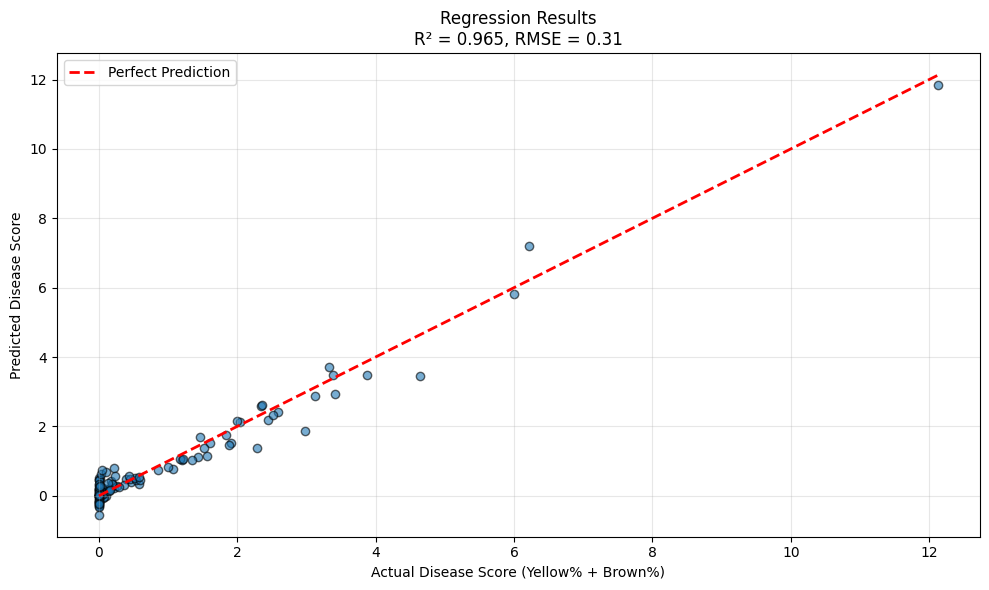

In [65]:
# Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.6, edgecolors='k')
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Disease Score (Yellow% + Brown%)')
plt.ylabel('Predicted Disease Score')
plt.title(f'Regression Results\nR² = {r2:.3f}, RMSE = {rmse:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# TAHAP 6: DECISION TREE & RANDOM FOREST - KLASIFIKASI

Menggunakan fitur yang diekstrak untuk klasifikasi Healthy vs Leaf Spot

## Visualisasi hasil regresi

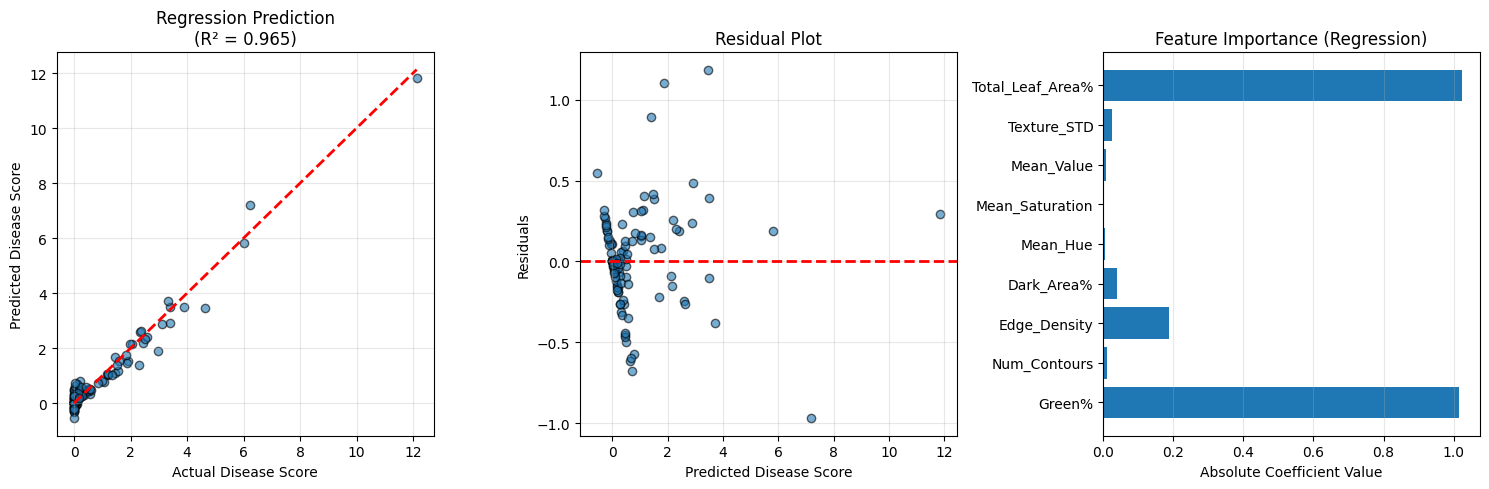

In [67]:
# Visualisasi hasil regresi dengan 3 subplot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_reg_test, y_reg_pred, alpha=0.6, edgecolors='k')
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Actual Disease Score')
plt.ylabel('Predicted Disease Score')
plt.title(f'Regression Prediction\n(R² = {r2:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
residuals = y_reg_test - y_reg_pred
plt.scatter(y_reg_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Disease Score')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
importance = np.abs(reg_model.coef_)
regression_feature_names = ['Green%', 'Num_Contours', 'Edge_Density', 'Dark_Area%',
                            'Mean_Hue', 'Mean_Saturation', 'Mean_Value', 'Texture_STD', 'Total_Leaf_Area%']
plt.barh(regression_feature_names, importance)
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Regression)')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Split data untuk klasifikasi

In [73]:
# Split data untuk machine learning classification
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    features_train, y_train, test_size=0.3, random_state=42
)

print(f"X_train_ml shape: {X_train_ml.shape}")
print(f"X_test_ml shape: {X_test_ml.shape}")
print(f"y_train_ml shape: {y_train_ml.shape}")
print(f"y_test_ml shape: {y_test_ml.shape}")

X_train_ml shape: (190, 11)
X_test_ml shape: (82, 11)
y_train_ml shape: (190,)
y_test_ml shape: (82,)


## Decision Tree

In [74]:
print("\n--- DECISION TREE ---")
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_ml, y_train_ml)
y_pred_dt = dt_model.predict(X_test_ml)

dt_accuracy = accuracy_score(y_test_ml, y_pred_dt)
print(f"Accuracy: {dt_accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_ml, y_pred_dt, target_names=CATEGORIES))

print("\nConfusion Matrix:")
cm_dt = confusion_matrix(y_test_ml, y_pred_dt)
print(cm_dt)


--- DECISION TREE ---
Accuracy: 0.805

Classification Report:
              precision    recall  f1-score   support

       sehat       0.81      0.85      0.83        20
yellow_light       0.61      0.92      0.73        12
     kriting       0.95      0.62      0.75        29
   leaf_spot       0.83      0.95      0.89        21

    accuracy                           0.80        82
   macro avg       0.80      0.83      0.80        82
weighted avg       0.84      0.80      0.80        82


Confusion Matrix:
[[17  1  1  1]
 [ 0 11  0  1]
 [ 3  6 18  2]
 [ 1  0  0 20]]


## Random Forest

In [70]:
print("\n--- RANDOM FOREST ---")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_ml, y_train_ml)
y_pred_rf = rf_model.predict(X_test_ml)

rf_accuracy = accuracy_score(y_test_ml, y_pred_rf)
print(f"Accuracy: {rf_accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_ml, y_pred_rf, target_names=CATEGORIES))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test_ml, y_pred_rf)
print(cm_rf)


--- RANDOM FOREST ---
Accuracy: 0.909

Classification Report:
              precision    recall  f1-score   support

       sehat       0.87      0.87      0.87        15
yellow_light       0.82      1.00      0.90         9
     kriting       0.94      0.83      0.88        18
   leaf_spot       1.00      1.00      1.00        13

    accuracy                           0.91        55
   macro avg       0.91      0.93      0.91        55
weighted avg       0.91      0.91      0.91        55


Confusion Matrix:
[[13  1  1  0]
 [ 0  9  0  0]
 [ 2  1 15  0]
 [ 0  0  0 13]]


## Visualisasi Decision Tree

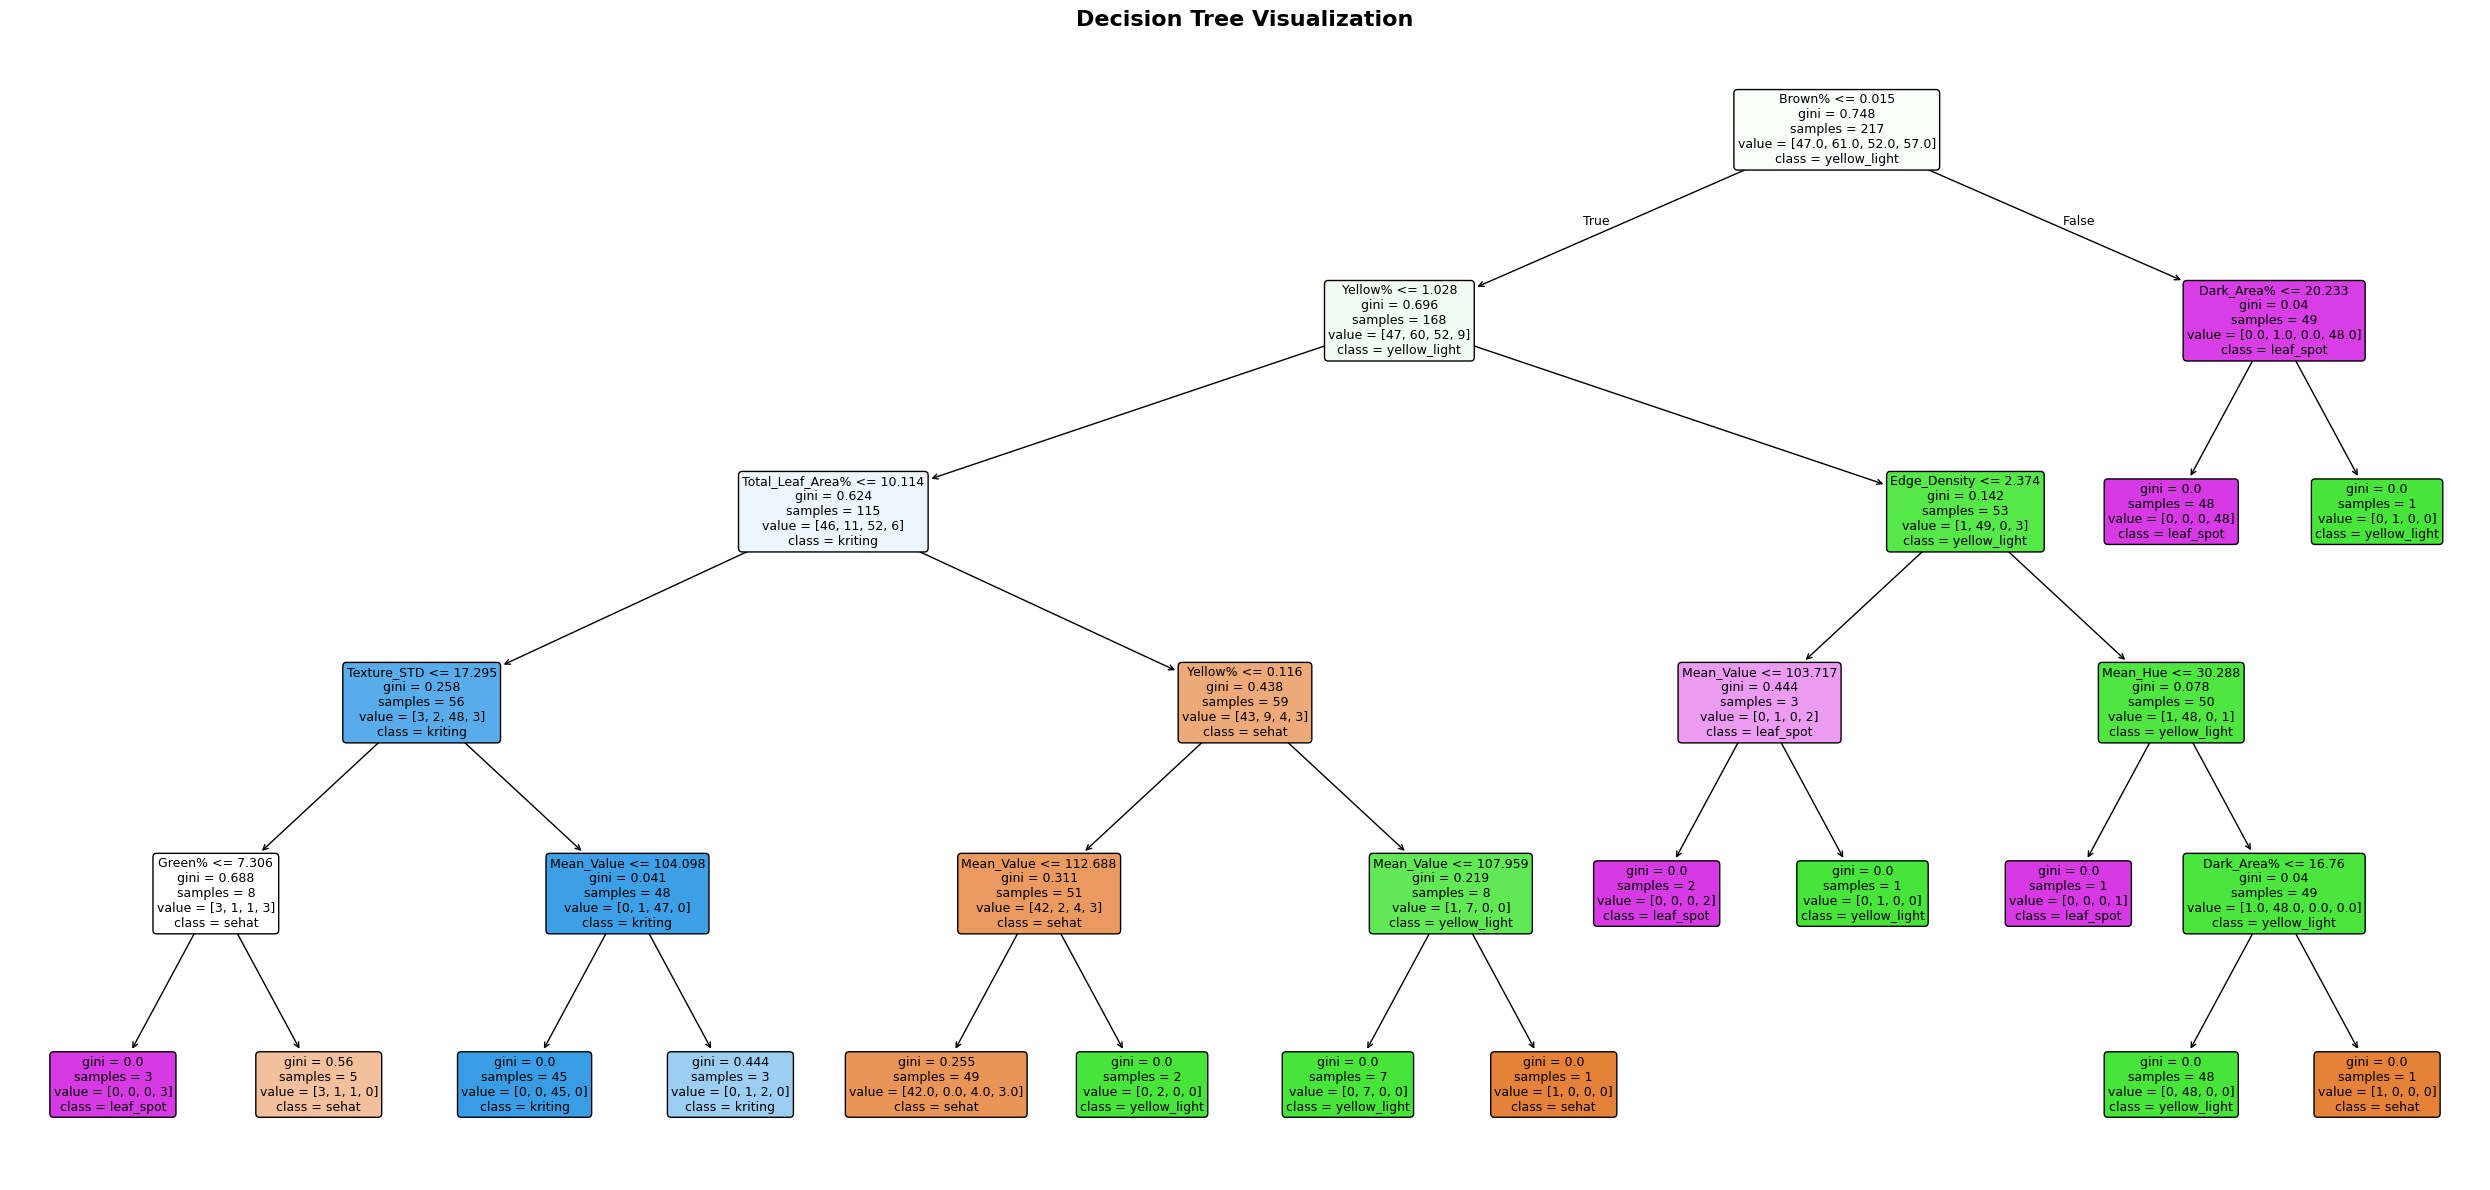

In [71]:
# Visualisasi Decision Tree
plt.figure(figsize=(25, 12))
tree.plot_tree(dt_model,
               feature_names=feature_names,
               class_names=CATEGORIES,
               filled=True,
               rounded=True,
               fontsize=9)
plt.title("Decision Tree Visualization", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Feature Importance & Confusion Matrix RF

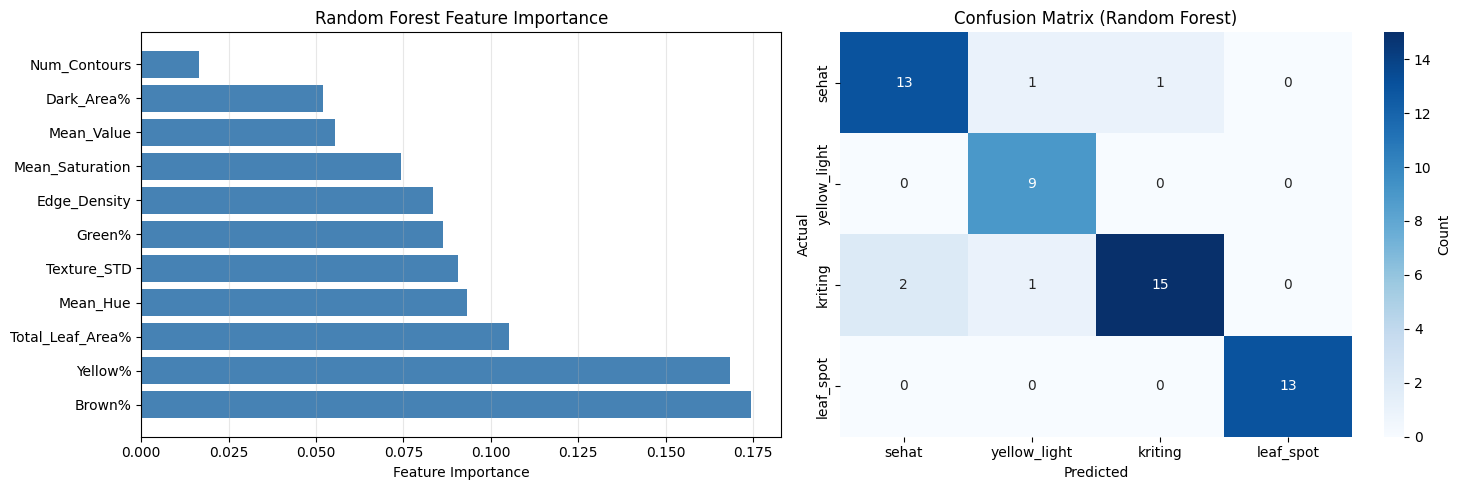

In [76]:
plt.figure(figsize=(15, 5))

# Feature Importance
plt.subplot(1, 2, 1)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh(range(len(importances)), importances[indices], color='steelblue')
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.grid(True, alpha=0.3, axis='x')

# Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=CATEGORIES, yticklabels=CATEGORIES, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')

plt.tight_layout()
plt.show()

## Perbandingan performa Decision Tree vs Random Forest

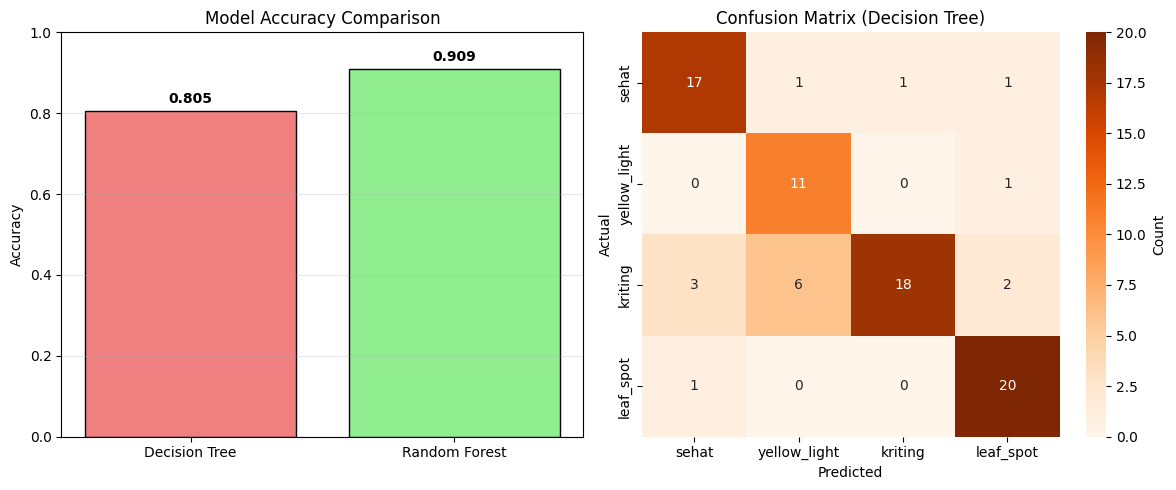

In [77]:
plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
models = ['Decision Tree', 'Random Forest']
accuracies = [dt_accuracy, rf_accuracy]
colors = ['lightcoral', 'lightgreen']
plt.bar(models, accuracies, color=colors, edgecolor='black')
plt.ylim([0, 1.0])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# Confusion Matrix Decision Tree
plt.subplot(1, 2, 2)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges',
            xticklabels=CATEGORIES, yticklabels=CATEGORIES, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decision Tree)')

plt.tight_layout()
plt.show()

# Contoh prediksi 1 sample random dari data testing

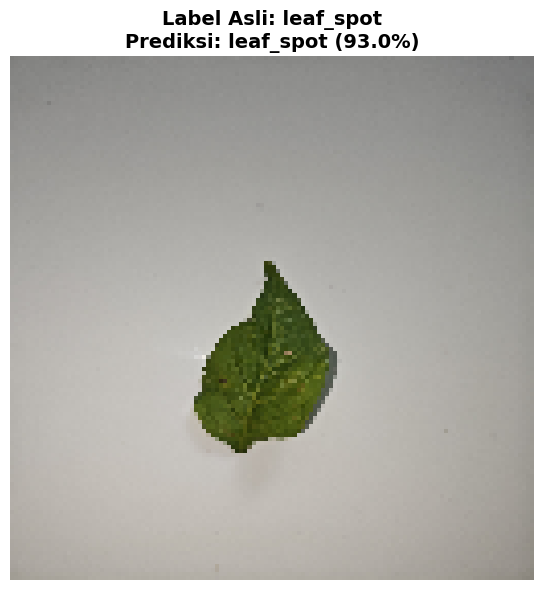


Hasil Prediksi: leaf_spot
Label Asli: leaf_spot
Status: ✓ BENAR


In [94]:
idx = np.random.randint(0, len(X_test_raw))

# Ambil gambar dan label asli
test_image = X_test_raw[idx]
true_label = y_test[idx]
true_class = CATEGORIES[true_label]

# Ekstrak fitur dari gambar
test_features = np.array(extract_features(test_image)).reshape(1, -1)

# Prediksi menggunakan Random Forest
pred_rf = rf_model.predict(test_features)[0]
pred_class_rf = CATEGORIES[pred_rf]
prob_rf = rf_model.predict_proba(test_features)[0]

# Visualisasi
plt.figure(figsize=(8, 6))
img_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title(f"Label Asli: {true_class}\nPrediksi: {pred_class_rf} ({prob_rf[pred_rf]*100:.1f}%)",
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nHasil Prediksi: {pred_class_rf}")
print(f"Label Asli: {true_class}")
print(f"Status: {'✓ BENAR' if pred_rf == true_label else '✗ SALAH'}")

# Save Models

In [95]:
import pickle

MODEL_DIR = "/content/drive/MyDrive/models"

# Buat folder jika belum ada
os.makedirs(MODEL_DIR, exist_ok=True)

# Simpan model Random Forest (untuk klasifikasi)
with open(os.path.join(MODEL_DIR, 'random_forest_model.pkl'), 'wb') as f:
    pickle.dump(rf_model, f)
print("✓ Random Forest model berhasil disimpan!")

# Simpan model Decision Tree (untuk klasifikasi)
with open(os.path.join(MODEL_DIR, 'decision_tree_model.pkl'), 'wb') as f:
    pickle.dump(dt_model, f)
print("✓ Decision Tree model berhasil disimpan!")

# Simpan model Linear Regression (untuk prediksi disease score)
with open(os.path.join(MODEL_DIR, 'regression_model.pkl'), 'wb') as f:
    pickle.dump(reg_model, f)
print("✓ Regression model berhasil disimpan!")

# Simpan juga nama-nama kategori dan fitur untuk keperluan load nanti
metadata = {
    'categories': CATEGORIES,
    'feature_names': feature_names
}
with open(os.path.join(MODEL_DIR, 'metadata.pkl'), 'wb') as f:
    pickle.dump(metadata, f)
print("✓ Metadata berhasil disimpan!")

print(f"\nSemua model tersimpan di: {MODEL_DIR}")

✓ Random Forest model berhasil disimpan!
✓ Decision Tree model berhasil disimpan!
✓ Regression model berhasil disimpan!
✓ Metadata berhasil disimpan!

Semua model tersimpan di: /content/drive/MyDrive/models
